In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import numpy as np

import ray
import models
import random,time
from time import sleep
import copy 
import datetime
import argparse
import sys


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import os
import shutil
from torch.utils.tensorboard import SummaryWriter
from filelock import FileLock

/userhome/34/gyu/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/userhome/34/gyu/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/userhome/34/gyu/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

In [4]:
ckpt_file = '/userhome/34/gyu/git-repo/rethinking-network-pruning/cifar/network-slimming/iterative_pruning_2/train_50more_0001/checkpoint.pth.tar'
checkpoint = torch.load(ckpt_file)
model = models.__dict__['resnet'](dataset='cifar10', depth=164, cfg=checkpoint['cfg'])
model.load_state_dict(checkpoint['state_dict'])                



IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [10]:
total = 0

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        total += m.weight.data.shape[0]

bn = torch.zeros(total)

index = 0
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        size = m.weight.data.shape[0]
        bn[index:(index+size)] = m.weight.data.abs().clone() # 应该取绝对值
        index += size

sorted_bn, prev_idx = torch.sort(bn)


In [21]:
sorted_bn.numpy()

array([0.       , 0.       , 0.       , ..., 1.6949396, 1.6981441,
       1.935548 ], dtype=float32)

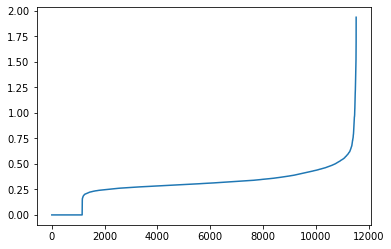

In [23]:
import pylab as pl
pl.plot(range(0,len(sorted_bn.numpy())),sorted_bn.numpy())
pl.show()

In [30]:
import pandas as pd 
s = pd.Series(sorted_bn)
s.value_counts()

0.000000    1150
0.325519       2
0.297599       2
0.319299       2
0.307520       2
            ... 
0.317709       1
0.263020       1
0.270832       1
0.403642       1
0.496150       1
Length: 10370, dtype: int64

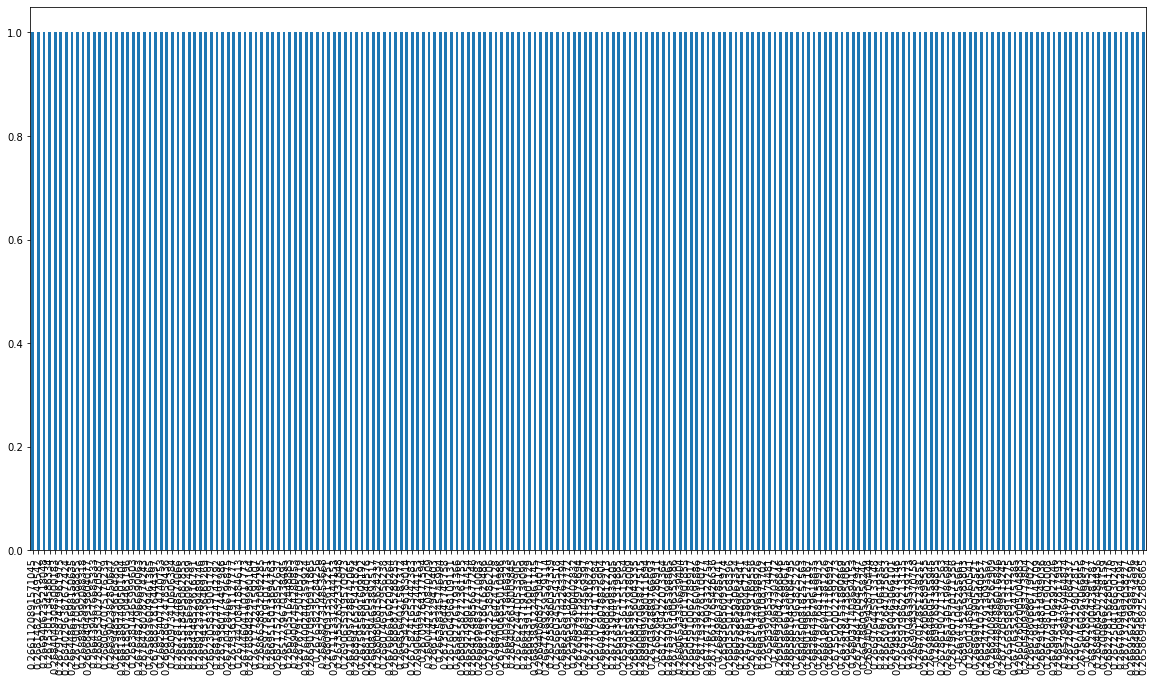

In [42]:
s[2800:3000].value_counts().plot.bar(figsize=(20,10))